In [18]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib as mpl 
import matplotlib.pyplot as plt


mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [19]:
pretrained_model = MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.trainable = False

decode_predictions = mobilenet_v2.decode_predictions

In [20]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = mobilenet_v2.preprocess_input(image)
    image =image[None, ...]
    return image

def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

In [21]:
image_path = 'Camel.jpg'
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


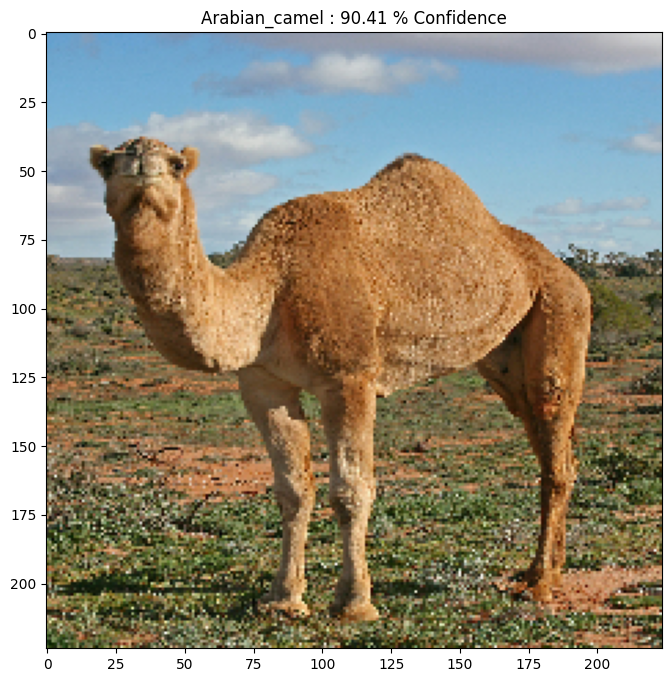

In [22]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f} % Confidence'.format(image_class, class_confidence*100))
plt.show()

In [23]:
loss_object = CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_lavel):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_lavel, prediction)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

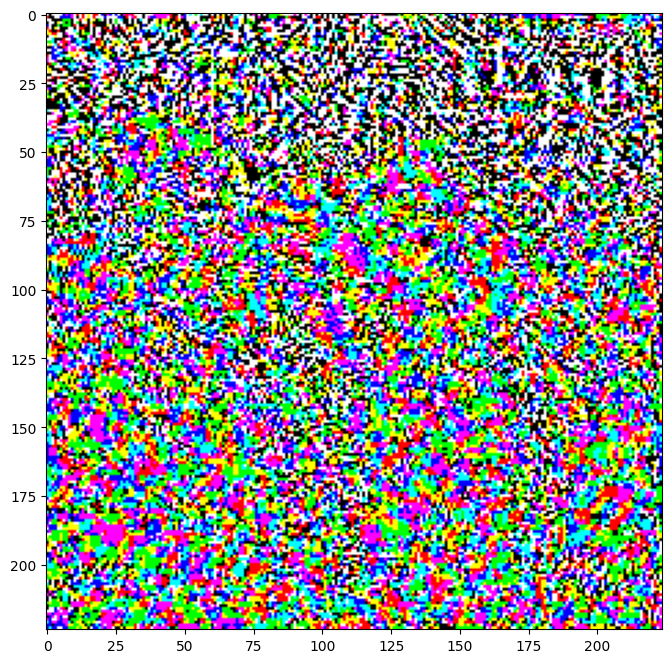

In [24]:
arabian_camel = 354
label = tf.one_hot(arabian_camel, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);

In [25]:
def display_images(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.Figure()
    plt.imshow(image[0] * 0.5 + 0.5)
    plt.title('{} \n {} : {:.2f} % Confidence' .format(description, label, confidence*100))
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


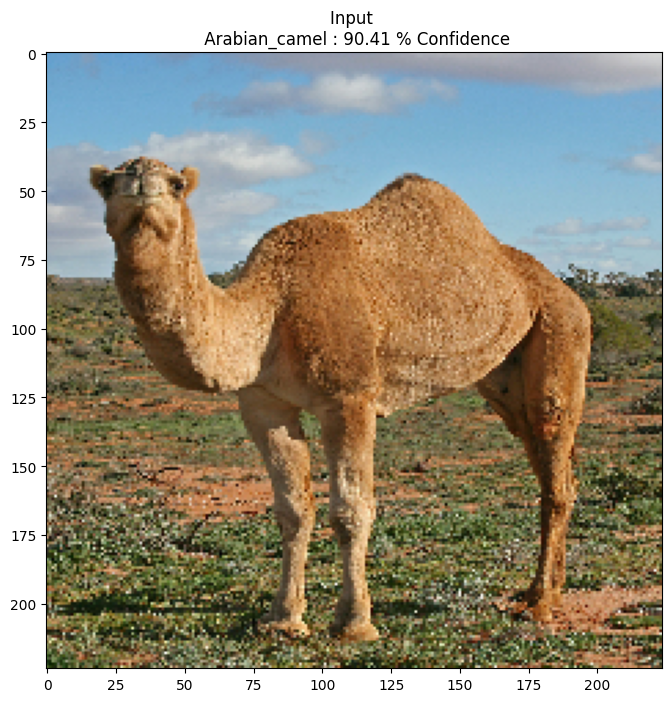

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


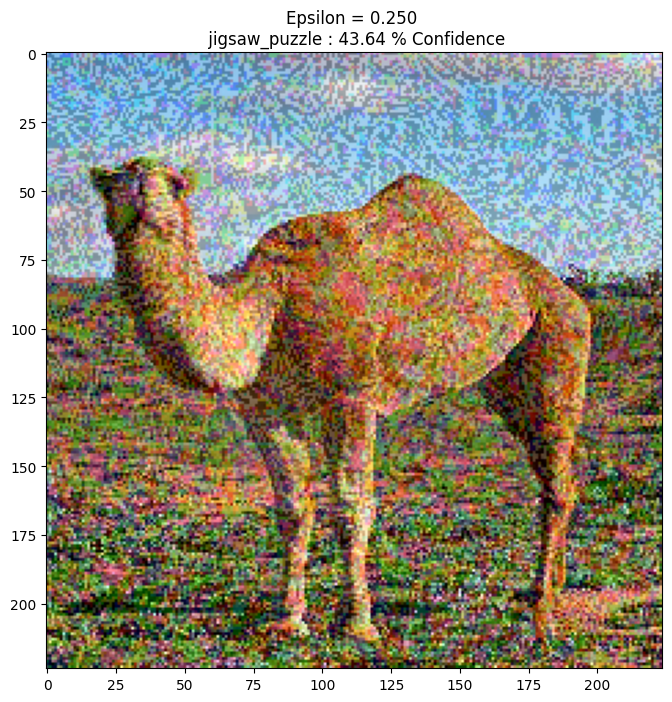

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


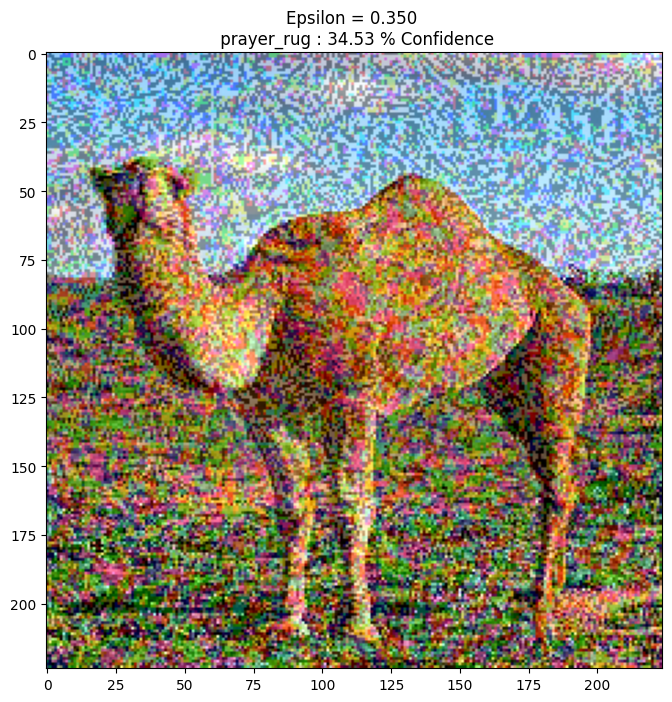

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


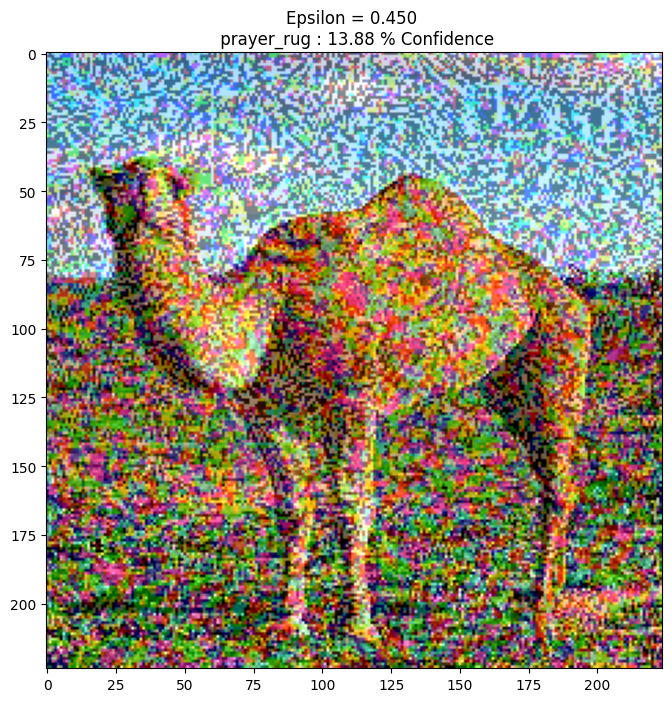

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


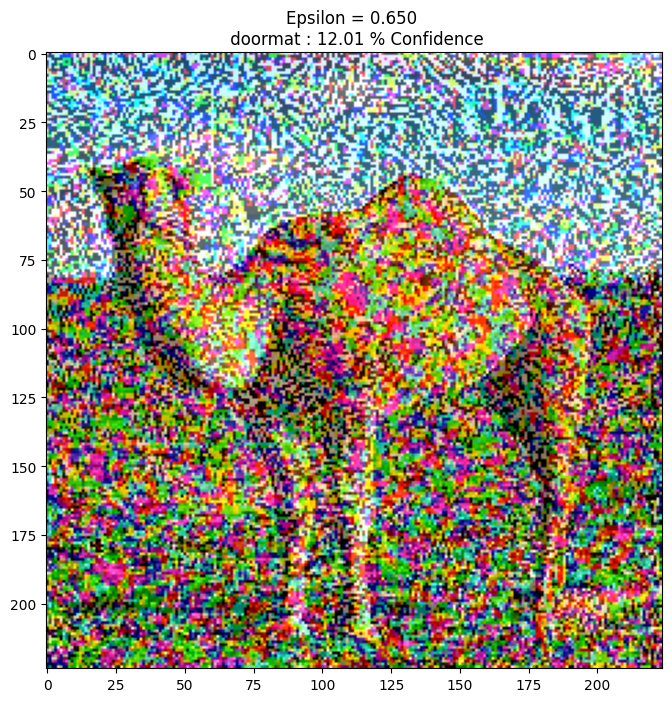

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


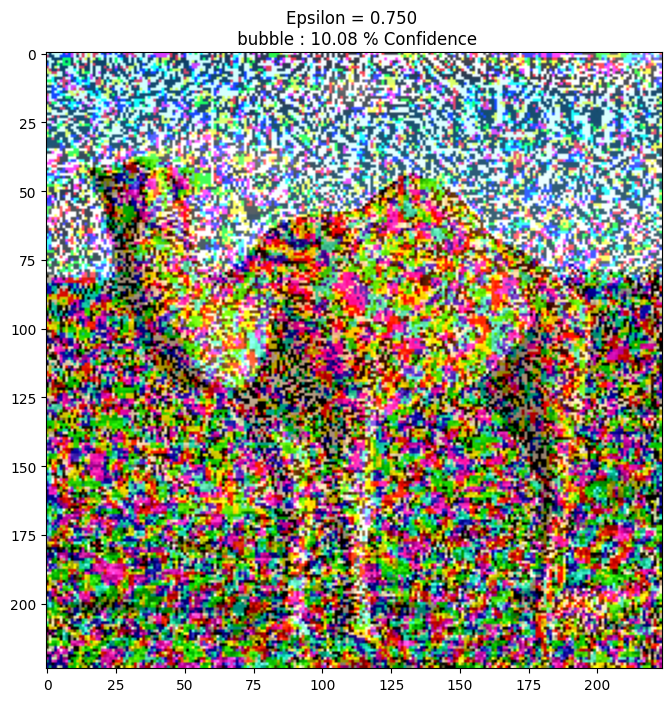

In [26]:
epsilons = [0, 0.25, 0.35, 0.45, 0.65, 0.75]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])